In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')


class Explain:
    def _make_feature_spaces(self, df : pd.DataFrame, cols: list):
        return {x : np.sort(df[x].unique()) for x in cols}

    def _make_cp_space(self, idx: int, x: np.ndarray, space: np.ndarray):
        tmp = []
        for v in space:
            tmp_x = x.copy()
            tmp_x[idx] = v
            tmp.append(tmp_x)
        return np.array(tmp)

    def partialdp(self, model, df: pd.DataFrame, n: int =100,
                 cols: list = [],  all: bool = False):
        """
        Takes model, dataframe, number od samples and list of column names /
        feature names for which pdp will be plotted. 
        If all then pdps are plotted for every feature
        """
        # Sanity...
        msg = 'Model has no predict method.'
        assert hasattr(model, 'predict_proba'), msg
        
        # Set default value to first column or take all columns
        if not all and len(cols) == 0:
            cols = [df.columns[0]]
        if all:
            cols = list(df.columns)
            
        smpl = df.sample(n)
        space = self._make_feature_spaces(df, cols)
        plot_data = dict()
        for i, c in enumerate(cols):
            plot_data[c] = [self._make_cp_space(i, x, space.get(c)) for x in smpl.values]
        
        fig = plt.figure(1, figsize=(20, 10))
        fig.suptitle('Partial Dependency Plots', fontsize=18)
        n = int(np.ceil(len(cols)/3))
        for i, d in enumerate(plot_data.items()):
            t, v = d
            plt.subplot(n, 3, i+1)
            plt.title(t)
            # ceteris paribus plots for samples
            tmp = []
            for s in v:
                y_hat = model.predict_proba(s)[:,1]
                tmp.append(y_hat)
                plt.plot(s[:,i], y_hat, color='black', alpha=0.2)
                
            # pdp 
            plt.plot(s[:,i], np.mean(tmp, axis=0), color='orange', linewidth=5, alpha=0.9)
        plt.show()

    def ceterisp(self, model, df: pd.DataFrame, x: np.ndarray, 
                 cols: list = [],  all: bool = False):

        # Sanity...
        if not isinstance(x, np.ndarray):
            x = np.array(x)
            
        assert x.size == df.shape[1], 'Sample and df sizes differ'
        msg = 'Model has no predict method.'
        assert hasattr(model, 'predict_proba'), msg
        
        # Set default value to first column or take all columns
        if not all and len(cols) == 0:
            cols = [df.columns[0]]
        if all:
            cols = list(df.columns)
        
        # Obtain spaces for each feature in cols
        space = self._make_feature_spaces(df, cols)
        
        # Create new samples based on x
        plot_data = {c: self._make_cp_space(i, x, space.get(c)) for i, c in enumerate(cols)}
        
        # Make plots
        fig = plt.figure(1, figsize=(20, 10))
        fig.suptitle('Ceteris Paribus Plots', fontsize=18)
        n = int(np.ceil(len(cols)/3))
        for i, d in enumerate(plot_data.items()):
            t, v = d
            plt.subplot(n, 3, i+1)
            plt.title(t)
            plt.plot(v[:,i], model.predict_proba(v)[:,1])
        plt.show()

# The lovely model

https://data.stanford.edu/hcmst2017


In [114]:
from random import randint

In [115]:
data = pd.read_stata('HCMST 2017 fresh sample for public sharing draft v1.1.dta')

In [116]:
#  ppmarit ppc21310 w6_q9 w6_q21a_year
cols = [data.columns[randint(2, 284)] for _ in range(8)]
data[cols].head(5)

,w6_friend_connect_2_3,Q21C_Month,PPREG4,w6_q21c_month,xlgb,Q15A7_2_1,Q28_2,hcm2017q24_met_through_friend
0,No,NaN,Northeast,NaN,LGB sample,I met [Partner Name] in [answer in Q15A7_2],No,no
1,NaN,February,Midwest,February,gen pop,NaN,NaN,no
2,NaN,July,South,July,gen pop,NaN,NaN,no
3,No,NaN,Midwest,NaN,gen pop,"I met [Partner Name] somewhere else , Please s...",No,no
4,NaN,August,South,August,gen pop,NaN,NaN,no


In [198]:
"""
ppmarit - Marital Status -> MAKE NO SENSE...

ppc21310 - How often do you USUALLY access the internet?
w6_19 - partner age in 2017
w6_q21a_year - year subject first met partner
hcm2017q24_internet_dating - met through Internet dating or phone app
duration - Interview duration in minutes
"""
cols = ['ppc21310', 'w6_q9', 'w6_q21a_year','hcm2017q24_internet_dating', 'duration', 'S1']
df = data[cols]
print(df.shape)
df = df.dropna()

cols = ['InternetAccessFrq', 'PartnerAge', 'FirstMetPartnerYr','InternetDating', 'InterviewDuration', 'S1']
df.columns = cols
print(df.shape)
print([(l, v) for l, v in zip(df.S1.values[:5], df.S1.values[:5].codes)])
df.head()

(3510, 6)
(3243, 6)
[('No, I am not Married', 1), ('Yes, I am Married', 0), ('Yes, I am Married', 0), ('No, I am not Married', 1), ('Yes, I am Married', 0)]


,InternetAccessFrq,PartnerAge,FirstMetPartnerYr,InternetDating,InterviewDuration,S1
0,Every day,26.0,2017.0,yes,9,"No, I am not Married"
1,Every day,52.0,1983.0,no,11,"Yes, I am Married"
2,Every day,45.0,2006.0,no,7,"Yes, I am Married"
3,Every day,26.0,2012.0,no,5,"No, I am not Married"
4,Every day,59.0,1983.0,no,13,"Yes, I am Married"


In [199]:
cat_cols = ['InternetAccessFrq', 'InternetDating','S1']
for c in cat_cols:
    df[c] = df[c].values.codes
    
# 'Yes, I am Married' = 0
# 'No, I am not Married' = 1
# But that's not intuitive...
df.S1 = [1 if x==0 else 0 for x in df.S1.values]
df.shape

(3243, 6)

In [200]:
# Well, PartnerAge = -1.0 ...?
df = df[df.PartnerAge > 0]
df.shape

(3231, 6)

In [201]:
np.quantile(data.duration.values, .90)

61.09999999999991

In [202]:
# It seems that InterviewDuration is not always expressed in minutes
# because 2 week-long interview seems impossible
df = df[df.InterviewDuration  < 60]
df.shape

(2900, 6)

In [203]:
from sklearn.model_selection import train_test_split
X = df[cols[:-1]]
y = df.S1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [204]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

grid = { 'max_depth': range(8, 256, 32)}

forest = RandomForestClassifier()
champion = GridSearchCV(estimator=forest, param_grid=grid,
                          scoring='accuracy', cv=5,
                          refit=True)

champion.fit(X_train, y_train)
forest = champion.best_estimator_

/Users/timmi/Desktop/Python/basic/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/timmi/Desktop/Python/basic/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/timmi/Desktop/Python/basic/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/timmi/Desktop/Python/basic/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/Users/timmi/Desktop/Python/basic/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/timmi/Desktop/Python/basic/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


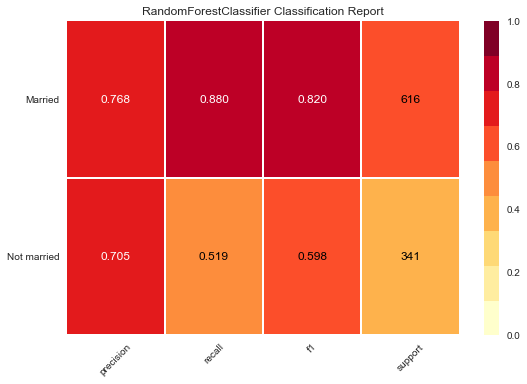

In [205]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the visualizer and new model
visualizer = ClassificationReport(forest, classes=['Not married', 'Married'], support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   

# Some meanigful plots

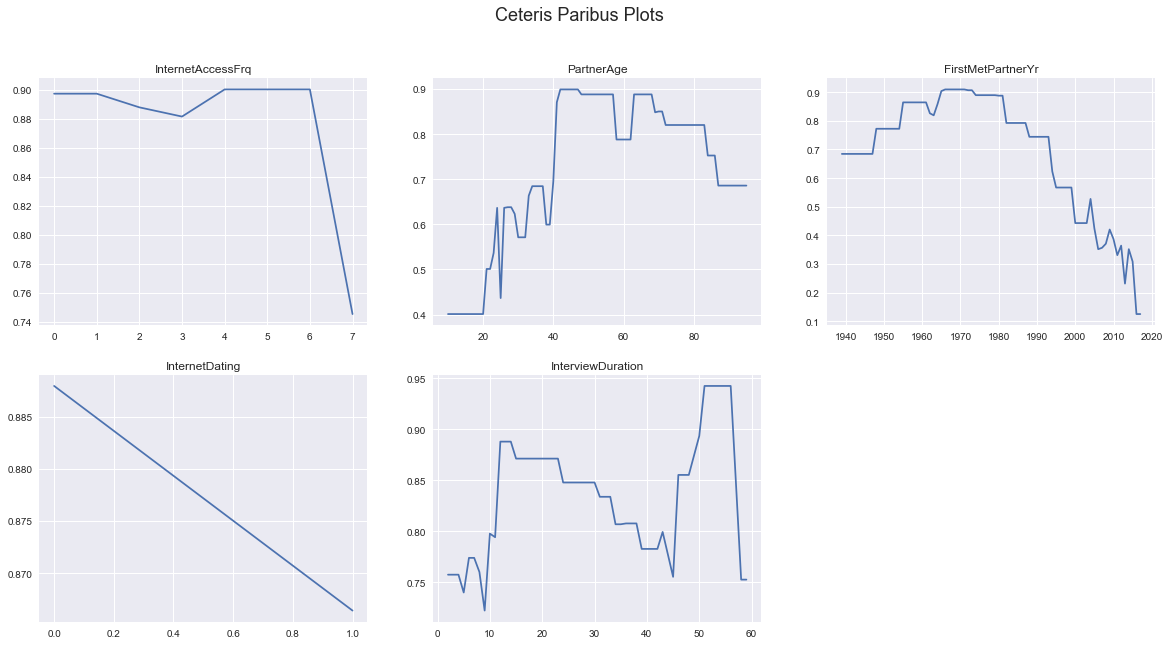

,InternetAccessFrq,PartnerAge,FirstMetPartnerYr,InternetDating,InterviewDuration
2448,2,66.0,1980.0,0,12


In [211]:
ex = Explain()
sample = X_test.sample(1)
dat = ex.ceterisp(forest, X, sample.values[0], all=True)
sample

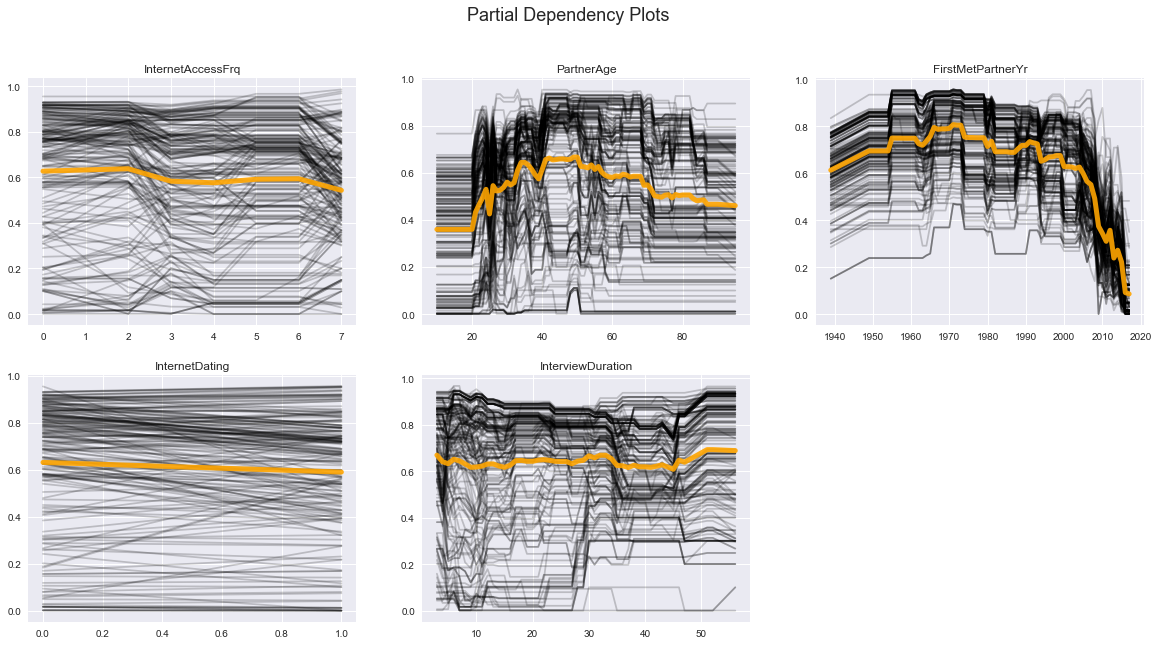

In [208]:
ex.partialdp(forest, X_test, n=200, all=True)